<a href="https://colab.research.google.com/github/GeneSUN/data-science-engineering/blob/main/Hierarchical_Models_with_Predictors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# 1. Download the CSV file
!wget https://vincentarelbundock.github.io/Rdatasets/csv/bayesrules/cherry_blossom_sample.csv

# 2. Load it into a pandas DataFrame
import pandas as pd

df = pd.read_csv("cherry_blossom_sample.csv")
df.head()
df.shape


--2026-02-15 17:55:55--  https://vincentarelbundock.github.io/Rdatasets/csv/bayesrules/cherry_blossom_sample.csv
Resolving vincentarelbundock.github.io (vincentarelbundock.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to vincentarelbundock.github.io (vincentarelbundock.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8545 (8.3K) [text/csv]
Saving to: ‘cherry_blossom_sample.csv.2’

cherry_blossom_samp 100%[===================>]   8.34K  --.-KB/s    in 0s      

2026-02-15 17:55:55 (43.7 MB/s) - ‘cherry_blossom_sample.csv.2’ saved [8545/8545]



(252, 7)

In [3]:
print(df_cherry_blossom.head(3))


   rownames  runner  age        net        gun  year  previous
0         1       1   53  83.983333  87.033333  2002         0
1         2       1   54  74.300000  74.566667  2003         1
2         3       1   55  75.150000  75.266667  2004         2


In [15]:
import numpy as np
import pandas as pd

# df columns: runner, age, net (others can exist)
# df = your dataframe

# Filter out rows where 'age' or 'net' are NaN
df = df.dropna(subset=["age", "net"])

# 1) Build X and y
X = df["age"].to_numpy(dtype=float)
y = df["net"].to_numpy(dtype=float)

# 2) Fit complete-pooled linear regression (OLS)
# net = b0 + b1*age
b1, b0 = np.polyfit(X, y, deg=1)  # returns slope, intercept

# 3) Residual SD (sigma_hat)
y_hat = b0 + b1 * X
resid = y - y_hat
sigma_hat = np.sqrt(np.sum(resid**2) / (len(y) - 2))  # df = n-2

results = {
    "beta0_hat (intercept)": np.round( float(b0),2),
    "beta1_hat (slope per 1 year age)": np.round( float(b1),2),
    "sigma_hat (residual SD)": np.round( float(sigma_hat),2),
    "n": int(len(y)),
}
results

{'beta0_hat (intercept)': np.float64(75.06),
 'beta1_hat (slope per 1 year age)': np.float64(0.27),
 'sigma_hat (residual SD)': np.float64(14.0),
 'n': 185}

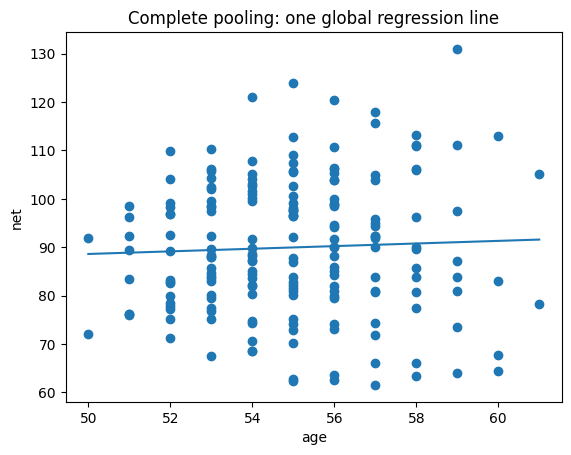

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X, y)
x_line = np.linspace(X.min(), X.max(), 100)
plt.plot(x_line, b0 + b1 * x_line)
plt.xlabel("age")
plt.ylabel("net")
plt.title("Complete pooling: one global regression line")
plt.show()


## Model A — varying intercept (each runner has their own baseline)

This assumes runners differ in overall speed, but age effect is shared.

- global intercept + global age slope
- runner-specific intercept drawn from a population distribution

In [23]:
!pip -q install bambi pymc arviz pandas numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 15.5 MB/s eta 0:00:00


In [24]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az


In [26]:
# df = your dataframe with columns: runner, age, net
df = df.copy()
df = df.dropna(subset=["age", "net"])
df["runner"] = df["runner"].astype("category")

model = bmb.Model("net ~ age + (1|runner)", data=df)
idata = model.fit(draws=2000, tune=2000, chains=4, target_accept=0.9, random_seed=84735)

az.summary(idata, var_names=["Intercept", "age"])


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,21.738,12.417,-0.862,46.163,0.200,0.132,3862.0,5194.0,1.0
age,1.243,0.221,0.809,1.643,0.003,0.002,5098.0,5390.0,1.0


### Predict a known runner (seen in training)

`kind="response"` gives you the full predictive distribution (not just the mean).

In [29]:
def summarize_draws(x, level=0.80):
    lo = np.quantile(x, (1-level)/2)
    hi = np.quantile(x, 1-(1-level)/2)
    return {"mean": float(np.mean(x)), f"{int(level*100)}%_interval": (float(lo), float(hi))}

new_known = pd.DataFrame({"runner": [1], "age": [60]})

pred_known = model.predict(
    idata,
    data=new_known,
    kind="response",
    inplace=False,
    include_group_specific=True,
    random_seed=84735,
)

# Bambi stores predictions in the returned InferenceData
y_known = pred_known.posterior_predictive["net"].values.reshape(-1)
summarize_draws(y_known, 0.80)


{'mean': 82.99201336295553,
 '80%_interval': (75.40891483014954, 90.47573098212874)}

### Predict an unknown runner (unseen group)
tell Bambi to sample a new group effect:

- known runner: uses that runner’s learned intercept (partially pooled)

- unknown runner: draws a fresh intercept from the learned “runner population” distribution

## Model B — varying intercept and varying age slope (more flexible)

If you believe different runners age differently:

- Each runner gets their own baseline and their own aging rate (slope).

- But these per-runner slopes are not independent; they come from a shared population distribution → partial pooling.


In [ ]:
model2 = bmb.Model("net ~ age + (1 + age|runner)", data=df)
idata2 = model2.fit(draws=2000, tune=2000, chains=4, target_accept=0.9, random_seed=84735)


## Appendix Manual Script

In [17]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

# df columns must include: runner, age, net
# runner can be int or string

# Filter out rows where 'age', 'net', or 'runner' are NaN
df_filtered_pymc = df.dropna(subset=["age", "net", "runner"])

# ---------- encode runner IDs ----------
runner_codes, runner_levels = pd.factorize(df_filtered_pymc["runner"])
j = runner_codes.astype(int)
J = len(runner_levels)

x = df_filtered_pymc["age"].to_numpy(float)
y = df_filtered_pymc["net"].to_numpy(float)

y_mean = y.mean()
y_sd = y.std(ddof=1) if len(y) > 1 else 1.0
x_sd = x.std(ddof=1) if len(x) > 1 else 1.0

with pm.Model() as running_random_intercept:

    # -------- Layer 3: priors (weak, data-scaled) --------
    beta0 = pm.Normal("beta0", mu=y_mean, sigma=10 * y_sd)               # global intercept
    beta1 = pm.Normal("beta1", mu=0.0, sigma=10 * (y_sd / max(x_sd, 1e-6)))  # global slope
    sigma_y = pm.HalfNormal("sigma_y", sigma=2 * y_sd)                   # within-runner noise

    # -------- Layer 2: how intercepts vary between runners --------
    sigma_b0 = pm.HalfNormal("sigma_b0", sigma=2 * y_sd)                 # between-runner SD
    b0 = pm.Normal("b0", mu=0.0, sigma=sigma_b0, shape=J)                # runner offsets
    beta0j = pm.Deterministic("beta0j", beta0 + b0)                      # runner-specific intercepts

    # -------- Layer 1: within-runner regression (your screenshot) --------
    mu_ij = beta0j[j] + beta1 * x
    y_obs = pm.Normal("y_obs", mu=mu_ij, sigma=sigma_y, observed=y)

    idata = pm.sample(2000, tune=2000, chains=4, target_accept=0.9, random_seed=84735)

# quick posterior summaries
az.summary(idata, var_names=["beta0", "beta1", "sigma_y", "sigma_b0"])

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,22.852,12.504,-0.678,46.274,0.244,0.137,2631.0,4255.0,1.0
beta1,1.228,0.223,0.800,1.644,0.004,0.002,3191.0,4329.0,1.0
sigma_y,5.234,0.310,4.683,5.838,0.004,0.004,7238.0,6096.0,1.0
sigma_b0,13.672,1.776,10.617,17.193,0.022,0.025,6712.0,4981.0,1.0


In [20]:
#@title Get runner-specific intercepts (so you can plot parallel lines):

# posterior mean intercept for each runner
beta0j_mean = idata.posterior["beta0j"].mean(dim=("chain","draw")).values
beta1_mean  = idata.posterior["beta1"].mean(dim=("chain","draw")).values.item()

runner_intercepts = pd.DataFrame({
    "runner": runner_levels,
    "beta0j_mean": beta0j_mean
})

runner_intercepts.head()


,runner,beta0j_mean
0,1,9.252910
1,2,17.826715
2,3,24.244039
3,4,34.888653
4,5,10.671120
